# Loading the Dataset

In [ ]:
import pandas as pd

file_path = "DATA.xlsx"
data = pd.read_excel(file_path)
data = data.rename(columns={"Consumption\n": "Consumption"})  
data = data.drop(columns=["Unnamed: 0"], errors="ignore") 
# Converting YEARS to a numerical index for time series analysis
data["YEAR"] = data["YEARS"].str.split('-').str[0].astype(int)
data = data[["YEAR", "Consumption"]]  


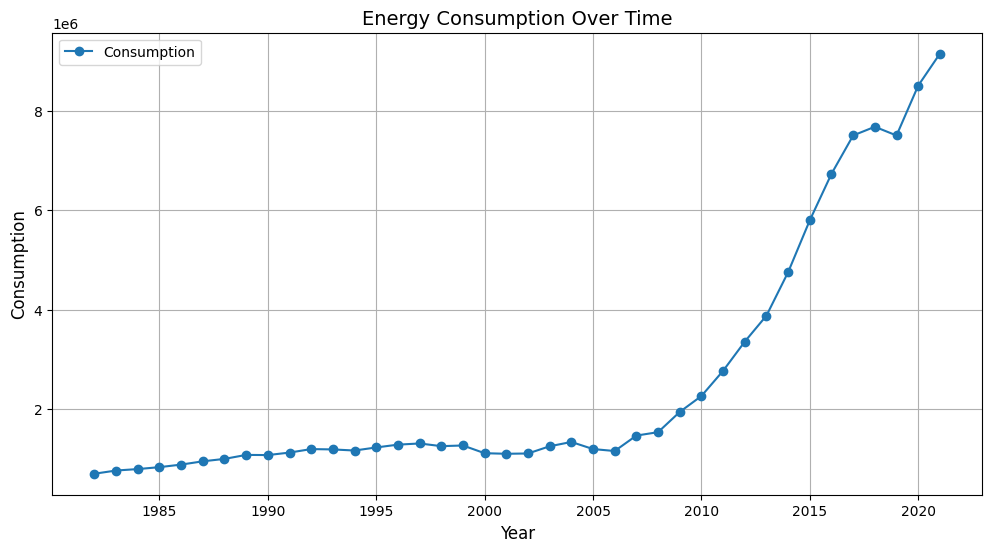

,YEAR,Consumption,Lag_1,Lag_2,Lag_3,Rolling_Mean_3
3,1982,690214.0,644907.0,589017.0,542254.0,641379.333333
4,1983,754725.0,690214.0,644907.0,589017.0,696615.333333
5,1984,783807.0,754725.0,690214.0,644907.0,742915.333333
6,1985,822735.0,783807.0,754725.0,690214.0,787089.000000
7,1986,874255.0,822735.0,783807.0,754725.0,826932.333333


In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(data["YEAR"], data["Consumption"], marker="o", label="Consumption")
plt.title("Energy Consumption Over Time", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Consumption", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


data.head()


## Let Proceed with creating new features

In [4]:
# Create lagged features and rolling averages
for lag in range(1, 4):  # Create lag features for the past 3 years
    data[f"Lag_{lag}"] = data["Consumption"].shift(lag)

# Rolling average over the past 3 years
data["Rolling_Mean_3"] = data["Consumption"].rolling(window=3).mean()

# Drop rows with NaN values due to lag/rolling operations
data = data.dropna()

# Display the enhanced dataset
data.head()


,YEAR,Consumption,Lag_1,Lag_2,Lag_3,Rolling_Mean_3
3,1982,690214.0,644907.0,589017.0,542254.0,641379.333333
4,1983,754725.0,690214.0,644907.0,589017.0,696615.333333
5,1984,783807.0,754725.0,690214.0,644907.0,742915.333333
6,1985,822735.0,783807.0,754725.0,690214.0,787089.000000
7,1986,874255.0,822735.0,783807.0,754725.0,826932.333333


## Splitting the Dataset 

In [5]:
from sklearn.model_selection import train_test_split

# Define features and target
features = ["Lag_1", "Lag_2", "Lag_3", "Rolling_Mean_3"]
X = data[features]
y = data["Consumption"]

# Split data: Use the last 10 years as test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, shuffle=False)


## Train the XGboost Model

In [6]:
from sklearn.model_selection import train_test_split
from xgboost import DMatrix, train
from sklearn.metrics import mean_absolute_error



params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "learning_rate": 0.05,  # Reduce learning rate
    "max_depth": 5,  # Control overfitting
    "subsample": 0.8,  # Randomly sample rows
    "colsample_bytree": 0.8,  # Randomly sample columns
    "random_state": 42
}

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DMatrix
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

# Train model with lag features
xgb_model = train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=10,
    verbose_eval=False
)

# Predictions
y_pred = xgb_model.predict(dtest)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error with Lag Features: {mae}")


Mean Absolute Error with Lag Features: 181760.80675368523


Mean Absolute Error (MAE): 181760.81
Mean Absolute Percentage Error (MAPE): 10.11%
Root Mean Squared Error (RMSE): 253496.53
R² Score: 0.99


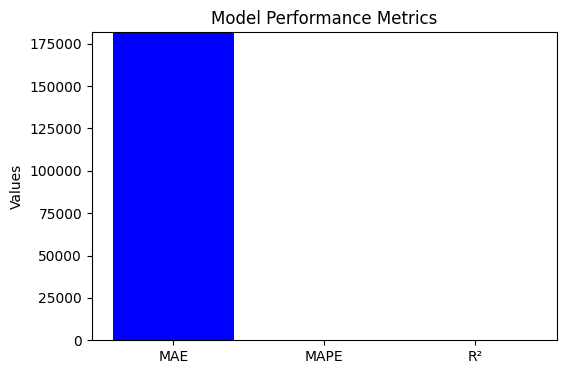

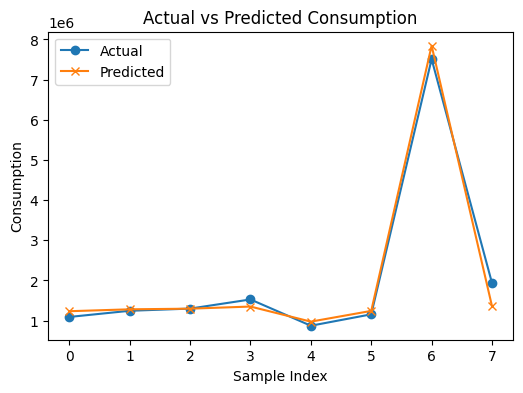

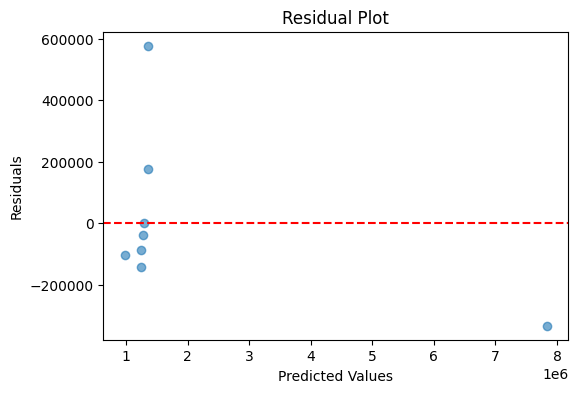

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import DMatrix, train
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions
y_pred = xgb_model.predict(dtest)

# Metrics Calculation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plotting the Results
metrics = ["MAE", "MAPE", "R²"]
values = [mae, mape, r2]

# Create bar plot
plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=["blue", "green", "orange"])
plt.title("Model Performance Metrics")
plt.ylabel("Values")
plt.ylim([0, max(values) + 10])
plt.show()

# Visualize Actual vs Predicted Values
plt.figure(figsize=(6, 4))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred, label="Predicted", marker='x')
plt.title("Actual vs Predicted Consumption")
plt.xlabel("Sample Index")
plt.ylabel("Consumption")
plt.legend()
plt.show()

# Residual Plot
# residuals = y_test - y_pred
# plt.figure(figsize=(6, 4))
# plt.scatter(y_pred, residuals, alpha=0.6)
# plt.axhline(y=0, color="red", linestyle="--")
# plt.title("Residual Plot")
# plt.xlabel("Predicted Values")
# plt.ylabel("Residuals")
# plt.show()


In [8]:
# Feature Importance Plot
xgb_model.save_model("model.json")  # Save model to extract feature importance
import json
with open("model.json", "r") as f:
    model_json = json.load(f)
importance = model_json["learner"]["gradient_booster"]["model"]["trees"]
print("Feature importance JSON:", importance)


Feature importance JSON: [{'base_weights': [47529.52, -1155121.5, 4048444.8, -73815.71, 498727.7, 52181.957, 222033.9, 2445.6562, 31618.076], 'categories': [], 'categories_nodes': [], 'categories_segments': [], 'categories_sizes': [], 'default_left': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'id': 0, 'left_children': [1, 3, 5, -1, 7, -1, -1, -1, -1], 'loss_changes': [124969060000000.0, 11360367000000.0, 2437041600000.0, 0.0, 209510990000.0, 0.0, 0.0, 0.0, 0.0], 'parents': [2147483647, 0, 0, 1, 1, 2, 2, 4, 4], 'right_children': [2, 4, 6, -1, 8, -1, -1, -1, -1], 'split_conditions': [3877984.0, 1935678.0, 4754295.0, -73815.71, 2764843.0, 52181.957, 222033.9, 2445.6562, 31618.076], 'split_indices': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'split_type': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'sum_hessian': [24.0, 19.0, 5.0, 16.0, 3.0, 1.0, 4.0, 1.0, 2.0], 'tree_param': {'num_deleted': '0', 'num_feature': '4', 'num_nodes': '9', 'size_leaf_vector': '1'}}, {'base_weights': [192062.11, -1063401.8, 3751664.2, -71202.89, 303377.7,

In [14]:
print("Minimum Consumption:", data["Consumption"].min())
print("Maximum Consumption:", data["Consumption"].max())
print("Mean Consumption:", data["Consumption"].mean())


Minimum Consumption: 822735.0
Maximum Consumption: 9158934.0
Mean Consumption: 2696236.293472176


## Let Forecast for next 10 years

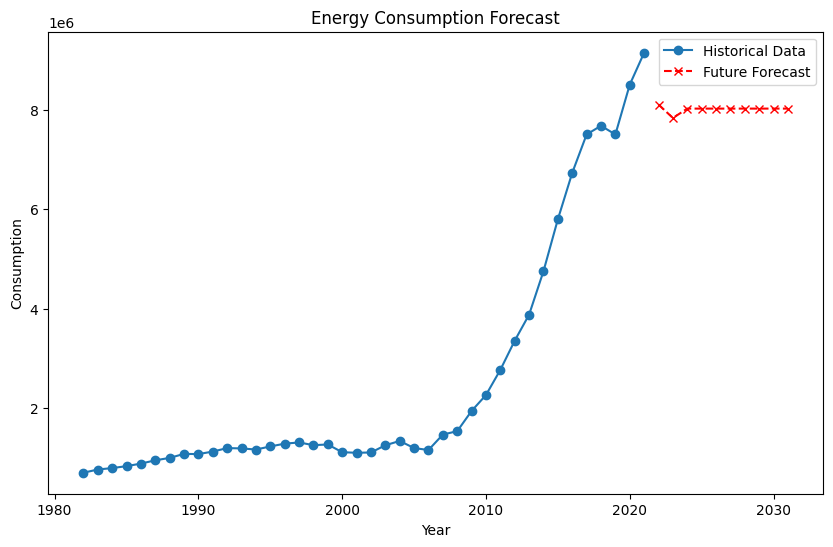

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

future_years = 10
last_known_data = data.iloc[-1].copy()

# Ensure consistent feature names (capitalize as used during training)
for lag in range(1, 4):  # Assuming 3 lag features
    if f"Lag_{lag}" not in last_known_data.index:
        last_known_data[f"Lag_{lag}"] = 0  # Initialize missing lags with 0 or another default value

future_predictions = []
for _ in range(future_years):
    # Prepare the input with consistent feature names
    future_input = pd.DataFrame([last_known_data.drop(["Consumption", "YEAR"])])  # Drop unnecessary columns
    dmatrix_future = DMatrix(future_input)  # Create a DMatrix for prediction

    # Predict the next value
    next_value = xgb_model.predict(dmatrix_future)[0]
    future_predictions.append(next_value)

    # Update lag features with consistent names
    for lag in range(3, 1, -1):  # Shift lag values
        last_known_data[f"Lag_{lag}"] = last_known_data[f"Lag_{lag - 1}"]
    last_known_data["Lag_1"] = next_value

# Generate the future years range
future_years_range = range(data["YEAR"].max() + 1, data["YEAR"].max() + 1 + future_years)

# Visualize future predictions
plt.figure(figsize=(10, 6))
plt.plot(data["YEAR"], data["Consumption"], label="Historical Data", marker="o")
plt.plot(future_years_range, future_predictions, label="Future Forecast", marker="x", linestyle="--", color="red")
plt.legend()
plt.title("Energy Consumption Forecast")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.show()


   YEAR  Forecasted_Consumption
0  2022               8114697.5
1  2023               7842824.0
2  2024               8032222.5
3  2025               8032222.5
4  2026               8032222.5
5  2027               8032222.5
6  2028               8032222.5
7  2029               8032222.5
8  2030               8032222.5
9  2031               8032222.5


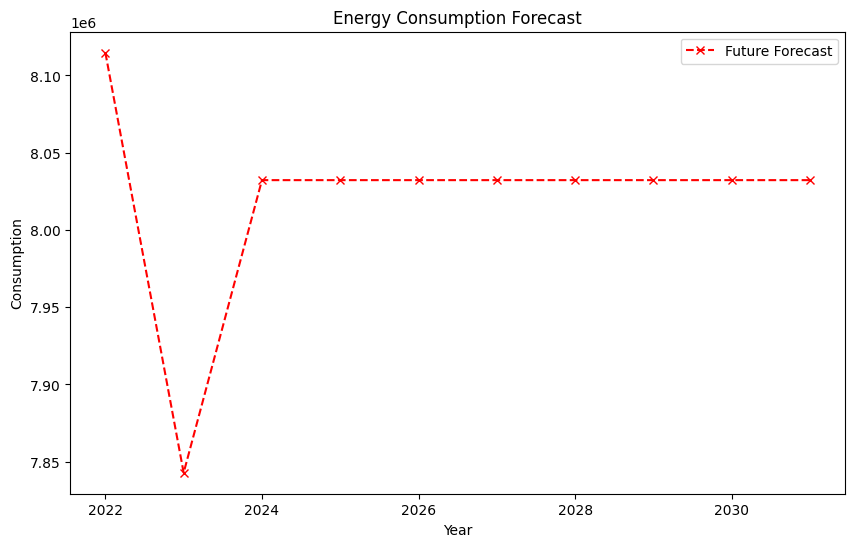

In [11]:
future_years = 10

# Copy the last known data for prediction
last_known_data = data.iloc[-1].copy()

# Ensure consistent feature names (capitalize as used during training)
for lag in range(1, 4):  # Assuming 3 lag features
    if f"Lag_{lag}" not in last_known_data.index:
        last_known_data[f"Lag_{lag}"] = 0  # Initialize missing lags with 0 or another default value

# List to store future predictions
future_predictions = []

# Perform predictions for the next 'future_years' years
for _ in range(future_years):
    # Prepare the input with consistent feature names
    future_input = pd.DataFrame([last_known_data.drop(["Consumption", "YEAR"])])  # Drop unnecessary columns
    dmatrix_future = DMatrix(future_input)  # Create a DMatrix for prediction

    # Predict the next value
    next_value = xgb_model.predict(dmatrix_future)[0]
    future_predictions.append(next_value)

    # Update lag features with consistent names
    for lag in range(3, 1, -1):  # Shift lag values
        last_known_data[f"Lag_{lag}"] = last_known_data[f"Lag_{lag - 1}"]
    last_known_data["Lag_1"] = next_value

# Generate the future years range
future_years_range = range(data["YEAR"].max() + 1, data["YEAR"].max() + 1 + future_years)

# Create a DataFrame for the forecasted values
forecasted_data = pd.DataFrame({
    "YEAR": future_years_range,
    "Forecasted_Consumption": future_predictions
})

# Display the forecasted data
print(forecasted_data)

# Visualize future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_years_range, future_predictions, label="Future Forecast", marker="x", linestyle="--", color="red")
plt.legend()
plt.title("Energy Consumption Forecast")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.show()